In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

visits_df = pd.read_csv('~/data/ms_exports/2024-visits-2024-09-20.csv')

# Convert 'checkin_time' to datetime
visits_df['checkin_time'] = pd.to_datetime(visits_df['checkin_time'], errors='coerce')

# Drop rows with invalid 'checkin_time'
visits_df = visits_df.dropna(subset=['checkin_time'])

# Ensure 'member_id' is a string
visits_df['acct_id'] = visits_df['acct_id'].astype(str)

In [2]:
# Average stay duration in hours
avg_stay_hours = 4

# Convert to a timedelta object
avg_stay_duration = pd.Timedelta(hours=avg_stay_hours)
# Calculate estimated check-out times
visits_df['estimated_checkout_time'] = visits_df['checkin_time'] + avg_stay_duration
# Preview the DataFrame
print("\nVisits with Estimated Check-Out Times:")
print(visits_df[['checkin_time', 'estimated_checkout_time']].head())


Visits with Estimated Check-Out Times:
         checkin_time estimated_checkout_time
0 2024-09-20 08:45:24     2024-09-20 12:45:24
1 2024-09-20 08:39:09     2024-09-20 12:39:09
2 2024-09-20 08:38:18     2024-09-20 12:38:18
3 2024-09-20 08:19:08     2024-09-20 12:19:08
4 2024-09-20 08:11:37     2024-09-20 12:11:37


In [3]:
# Create arrival events
arrivals = visits_df[['checkin_time']].copy()
arrivals['event'] = 'arrival'

# Create departure events
departures = visits_df[['estimated_checkout_time']].copy()
departures = departures.rename(columns={'estimated_checkout_time': 'event_time'})
departures['event'] = 'departure'

# Combine arrivals and departures
arrivals = arrivals.rename(columns={'checkin_time': 'event_time'})
events = pd.concat([arrivals, departures], ignore_index=True)

# Sort events by event time
events = events.sort_values('event_time').reset_index(drop=True)

# Assign +1 for arrivals and -1 for departures
events['guest_change'] = events['event'].map({'arrival': 1, 'departure': -1})

# Calculate cumulative guest count
events['guest_count'] = events['guest_change'].cumsum()

# Remove duplicates at the same timestamp (keep last to reflect cumulative count)
events = events.drop_duplicates(subset='event_time', keep='last')

# Set 'event_time' as the index
events = events.set_index('event_time')

# Resample to 15-minute intervals, forward-fill to maintain guest count
occupancy = events['guest_count'].resample('15T').last().ffill().reset_index()

# Preview the occupancy DataFrame
#print("\nOccupancy Data:")
#print(occupancy.head())

In [4]:
# Define maximum capacity
max_capacity = 417

# Add a column indicating capacity status
occupancy['exceeds_capacity'] = occupancy['guest_count'] > max_capacity

# Preview occupancy with capacity status
#print("\nOccupancy with Capacity Status:")
#print(occupancy.head())

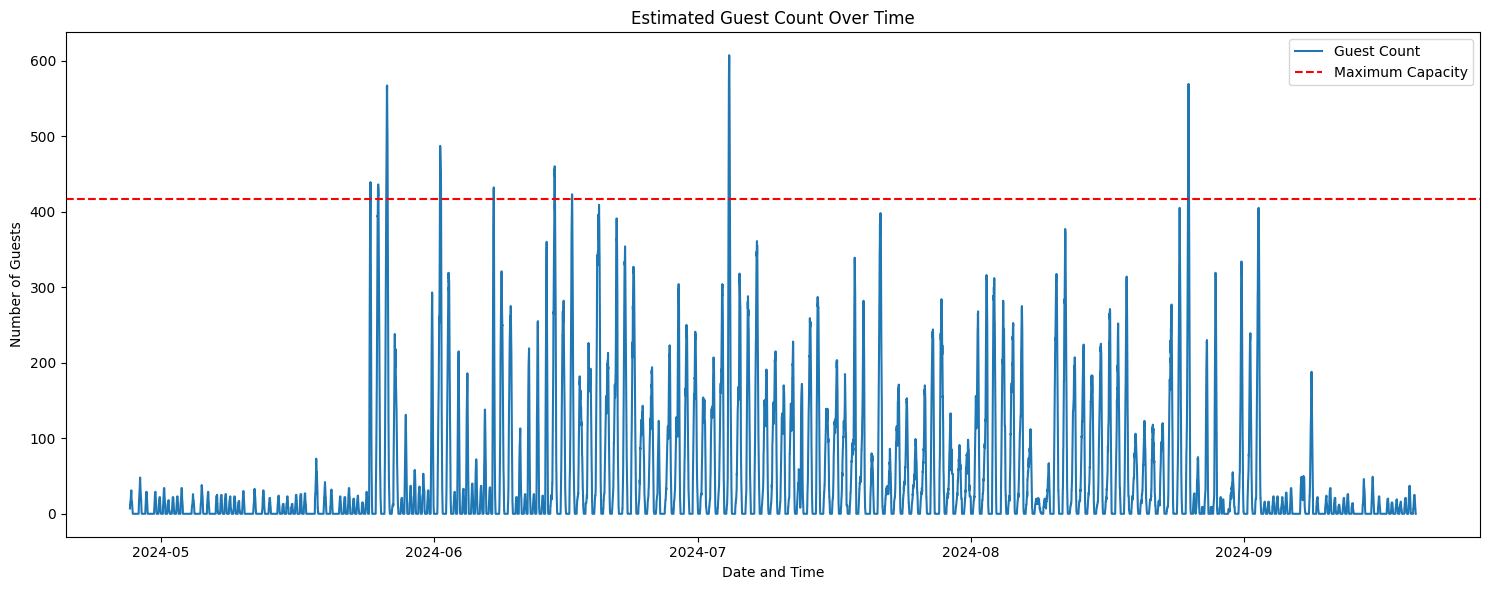

In [5]:
# Plot guest count over time
plt.figure(figsize=(15, 6))
plt.plot(occupancy['event_time'], occupancy['guest_count'], label='Guest Count')
plt.axhline(y=max_capacity, color='red', linestyle='--', label='Maximum Capacity')

# Highlight periods exceeding capacity
plt.fill_between(occupancy['event_time'], occupancy['guest_count'], max_capacity, where=occupancy['guest_count'] > max_capacity, color='red', alpha=0.3)

# Customize the plot
plt.title('Estimated Guest Count Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Number of Guests')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Add a date column
occupancy['date'] = occupancy['event_time'].dt.date

# Filter occupancy data where capacity is exceeded
exceeded_occupancy = occupancy[occupancy['exceeds_capacity']]
# Group by date and calculate statistics
exceeded_days = exceeded_occupancy.groupby('date').agg(
    max_guest_count=('guest_count', 'max'),
    total_exceeded_intervals=('guest_count', 'count')
).reset_index()

# Calculate total duration in hours (assuming each interval is 15 minutes)
exceeded_days['total_exceeded_duration_hours'] = exceeded_days['total_exceeded_intervals'] * (15 / 60)

# Drop 'total_exceeded_intervals' if not needed
exceeded_days = exceeded_days.drop(columns=['total_exceeded_intervals'])
# Display the table
print("Days When Estimated Occupancy Exceeded Maximum Capacity:")
print(exceeded_days)

Days When Estimated Occupancy Exceeded Maximum Capacity:
         date  max_guest_count  total_exceeded_duration_hours
0  2024-05-24            439.0                           1.00
1  2024-05-25            436.0                           1.50
2  2024-05-26            567.0                           3.75
3  2024-06-01            487.0                           3.00
4  2024-06-07            432.0                           0.75
5  2024-06-14            460.0                           1.25
6  2024-06-16            423.0                           0.25
7  2024-07-04            607.0                           3.75
8  2024-08-25            569.0                           3.25


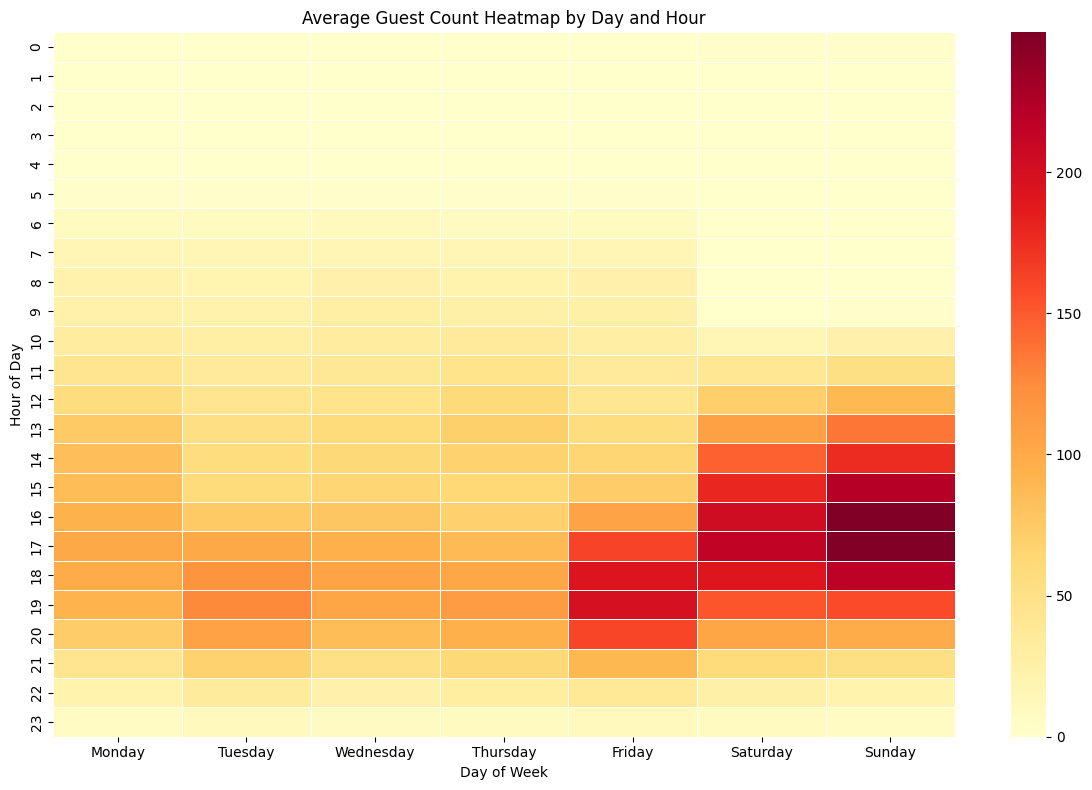

In [7]:
# Extract day of week and hour
occupancy['day_of_week'] = occupancy['event_time'].dt.day_name()
occupancy['hour'] = occupancy['event_time'].dt.hour

# Create a pivot table
heatmap_data = occupancy.pivot_table(index='hour', columns='day_of_week', values='guest_count', aggfunc='mean')

# Reorder the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[days_order]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5, linecolor='white')

# Customize the heatmap
plt.title('Average Guest Count Heatmap by Day and Hour')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()